# Step 1: Data Collection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_2019 = pd.read_excel("DATAv3.xlsx", sheet_name="2019")
df_2020 = pd.read_excel("DATAv3.xlsx", sheet_name="2020")
df_2021 = pd.read_excel("DATAv3.xlsx", sheet_name="2021")
df_2022 = pd.read_excel("DATAv3.xlsx", sheet_name="2022")
df_2023 = pd.read_excel("DATAv3.xlsx", sheet_name="2023")

In [3]:
merged_df = pd.concat([df_2019, df_2020], axis=0)
merged_df = pd.concat([merged_df, df_2021], axis=0)
merged_df = pd.concat([merged_df, df_2022], axis=0)
merged_df = pd.concat([merged_df, df_2023], axis=0)

In [4]:
columns_to_keep = merged_df.columns[:19]
columns_to_keep

Index(['CODE', 'NAME', 'STOCK EXCHANGE', 'YEAR', 'TARGET', 'EBIT', 'EBITDA',
       'TOTAL EQUITY/TOTAL ASSETS', 'EPS', 'CASH/TOTAL CURRENT ASSETS',
       'TOTAL CURRENT ASSET/TOTAL ASSET', 'LONG-TERM ASSETS/TOTAL ASSETS',
       'QUICK RATIO',
       'Market Value of Total Equity / Book Values of Total Liabilities',
       'Sales/Total Assets', 'EBIT/Total Assets',
       'Retain Earnings/Total Assets', 'Working Capitals/Total Asset', 'ROIC'],
      dtype='object')

In [5]:
merged_df = merged_df[columns_to_keep]
len(merged_df)

3303

# Step 2: Data Preprocessing

## 2.1 Conver object to float

In [6]:
def convert_string_to_float(x):
    if type(x) == str:
        x = x.replace("(", "")
        x = x.replace(")", "")
        x = x.replace(",", "")
        return float(x)
    return x

In [7]:
merged_df['EBIT'] = merged_df['EBIT'].apply(lambda x: convert_string_to_float(x))
merged_df['EBITDA'] = merged_df['EBITDA'].apply(lambda x: convert_string_to_float(x))
merged_df['TOTAL EQUITY/TOTAL ASSETS'] = merged_df['TOTAL EQUITY/TOTAL ASSETS'].apply(lambda x: convert_string_to_float(x))

## 2.2 Handling mising value

Biểu đồ số lượng giá trị bị thiếu đối với mỗi cột giá trị

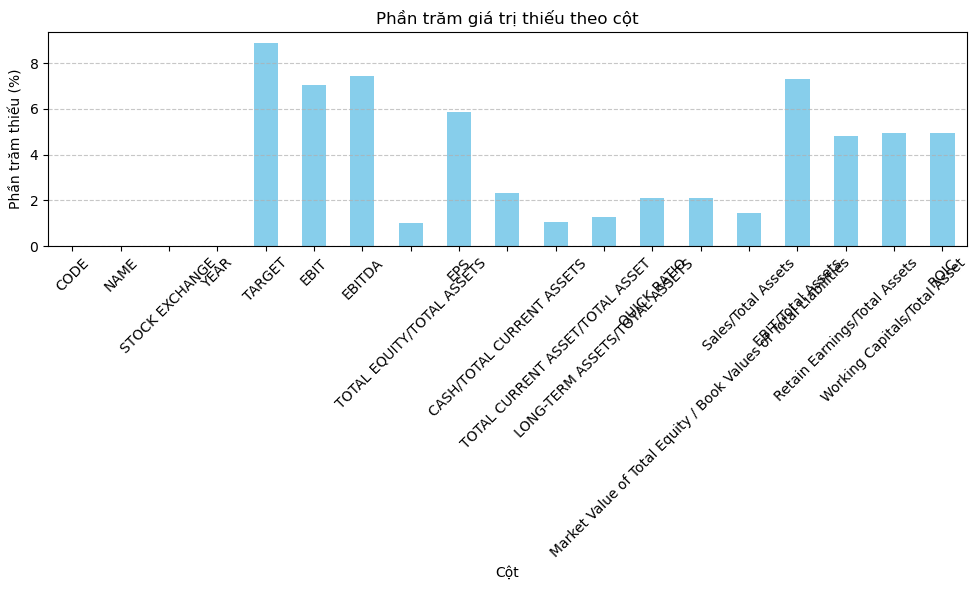

In [8]:
# Tính phần trăm giá trị thiếu cho mỗi cột
missing_percentage = merged_df.isnull().mean() * 100

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar', color='skyblue')
plt.title('Phần trăm giá trị thiếu theo cột')
plt.xlabel('Cột')
plt.ylabel('Phần trăm thiếu (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

*Nhận xét:* Những cột có nhiều giá trị bị thiếu nhất là 'TARGET', 'EPS', 'ROIC' 

In [9]:
merged_df.isna().sum()

CODE                                                                 0
NAME                                                                 0
STOCK EXCHANGE                                                       0
YEAR                                                                 0
TARGET                                                             294
EBIT                                                               233
EBITDA                                                             245
TOTAL EQUITY/TOTAL ASSETS                                           34
EPS                                                                193
CASH/TOTAL CURRENT ASSETS                                           76
TOTAL CURRENT ASSET/TOTAL ASSET                                     35
LONG-TERM ASSETS/TOTAL ASSETS                                       42
QUICK RATIO                                                         70
Market Value of Total Equity / Book Values of Total Liabilities     69
Sales/

In [10]:
for i in range(2019, 2024):
    df_name = f"df_{i}"
    target_column = f"{df_name}['TARGET']"
    missing_values = globals()[df_name]['TARGET'].isna().sum()
    print(f"Missing values in {df_name}: {missing_values}")

Missing values in df_2019: 73
Missing values in df_2020: 48
Missing values in df_2021: 43
Missing values in df_2022: 44
Missing values in df_2023: 86


*Nhận xét:* Những dòng bị thiếu giá trị ở cột TARGET thường cũng thiếu ở những cột còn lại => Xóa đi những dòng dữ liệu bị thiếu ở cột TARGET

In [11]:
merged_df.dropna(subset=['TARGET'], inplace=True)

Xóa những dòng dữ liệu bị thiếu ít giá trị ở một số cột

In [12]:
merged_df.dropna(subset=['EBITDA',
                         'CASH/TOTAL CURRENT ASSETS',
                         'TOTAL CURRENT ASSET/TOTAL ASSET',
                         'Working Capitals/Total Asset',
                         'LONG-TERM ASSETS/TOTAL ASSETS',
                         'Market Value of Total Equity / Book Values of Total Liabilities',
                         'Working Capitals/Total Asset'], inplace=True)


Xóa những dòng bị thiếu ở cả hai cột EPS và ROIC

In [13]:
merged_df.dropna(subset=['EPS', 'ROIC'], how='all', inplace=True)


Lọc ra những giá trị thiếu ở EPS và ROIC

In [14]:
df_na_EPS = merged_df[merged_df['EPS'].isna()]
df_na_ROIC = merged_df[merged_df['ROIC'].isna()]
merged_df_not_na = merged_df.dropna()

In [15]:
len(df_na_EPS), len(df_na_ROIC), len(merged_df_not_na)

(62, 7, 2923)

Xác định các biến đặc trưng và các biến mục tiêu

In [16]:
feature_merged_df_not_na = merged_df_not_na.drop(['CODE', 'NAME', 'STOCK EXCHANGE', 'YEAR', 'TARGET'], axis=1)
feartures_EPS = feature_merged_df_not_na.drop(['EPS'], axis=1)
target_EPS = feature_merged_df_not_na['EPS']
feature_ROIC = feature_merged_df_not_na.drop(['ROIC'], axis=1)
target_ROIC = feature_merged_df_not_na['ROIC']

In [17]:
from sklearn.ensemble import RandomForestRegressor


# Tính toán giá trị bias
mean_target_EPS = target_EPS.mean()
mean_target_ROIC = target_ROIC.mean()
# 10% giá trị trung bình của cột target_column
bias_EPS = 0.1 * mean_target_EPS  
bias_ROIC = 0.1 * mean_target_ROIC


# Xây dựng mô hình Random Forest
model1 = RandomForestRegressor()
model2 = RandomForestRegressor()

model1.fit(feartures_EPS, target_EPS)
model2.fit(feature_ROIC, target_ROIC)



RandomForestRegressor()

Dự đoán giá trị bị thiếu bằng thuật toán Random forest + bias
Bias là một lượng random 10% giá trị trung bình của cột

In [18]:
# Dự đoán giá trị thiếu
predicted_values_EPS = model1.predict(df_na_EPS.drop(['CODE', 'NAME', 'STOCK EXCHANGE', 'YEAR', 'TARGET', 'EPS'], axis=1))
predicted_values_ROIC = model2.predict(df_na_ROIC.drop(['CODE', 'NAME', 'STOCK EXCHANGE', 'YEAR', 'TARGET', 'ROIC'], axis=1))

# Thêm bias ngẫu nhiên vào giá trị dự đoán
random_bias_EPS = np.random.uniform(-bias_EPS, bias_EPS, len(predicted_values_EPS))
random_bias_ROIC = np.random.uniform(-bias_ROIC, bias_ROIC, len(predicted_values_ROIC))

predicted_values_with_bias_EPS = predicted_values_EPS + random_bias_EPS
predicted_values_with_bias_ROIC = predicted_values_ROIC + random_bias_ROIC

# Điền giá trị thiếu vào dữ liệu gốc
df_na_EPS['EPS'] = predicted_values_with_bias_EPS
df_na_ROIC['ROIC'] = predicted_values_with_bias_ROIC

# Kết hợp dữ liệu đã biết và dữ liệu đã dự đoán lại
final_data = pd.concat([merged_df_not_na, df_na_EPS], axis=0)
final_data = pd.concat([final_data, df_na_ROIC], axis=0)


/tmp/ipykernel_24689/3260561891.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na_EPS['EPS'] = predicted_values_with_bias_EPS
/tmp/ipykernel_24689/3260561891.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na_ROIC['ROIC'] = predicted_values_with_bias_ROIC


In [19]:
final_data.isna().sum()

CODE                                                               0
NAME                                                               0
STOCK EXCHANGE                                                     0
YEAR                                                               0
TARGET                                                             0
EBIT                                                               0
EBITDA                                                             0
TOTAL EQUITY/TOTAL ASSETS                                          0
EPS                                                                0
CASH/TOTAL CURRENT ASSETS                                          0
TOTAL CURRENT ASSET/TOTAL ASSET                                    0
LONG-TERM ASSETS/TOTAL ASSETS                                      0
QUICK RATIO                                                        0
Market Value of Total Equity / Book Values of Total Liabilities    0
Sales/Total Assets                

In [20]:
final_data.to_csv("final_data.csv", index=False)

## 2.3 Describe Static

In [21]:
final_data.describe()

,YEAR,TARGET,EBIT,EBITDA,TOTAL EQUITY/TOTAL ASSETS,EPS,CASH/TOTAL CURRENT ASSETS,TOTAL CURRENT ASSET/TOTAL ASSET,LONG-TERM ASSETS/TOTAL ASSETS,QUICK RATIO,Market Value of Total Equity / Book Values of Total Liabilities,Sales/Total Assets,EBIT/Total Assets,Retain Earnings/Total Assets,Working Capitals/Total Asset,ROIC
count,2992.000000,2992.000000,2.992000e+03,2.992000e+03,2992.000000,2.992000e+03,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000
mean,2020.979612,0.456551,4.738623e+08,6.281996e+08,208.299082,1.628128e+04,5.379692,26.496562,19.152041,2.068610,3.659664,2.151790,0.000211,0.000323,0.000397,8.502279
std,1.392024,0.498192,2.473091e+09,2.944223e+09,2996.203974,1.533142e+05,11.525559,44.887097,64.243405,4.876866,11.558535,13.442135,0.002125,0.002837,0.002393,11.805158
min,2019.000000,0.000000,-1.215827e+10,-1.010885e+10,-0.208426,-3.286260e+05,0.000000,0.000347,-0.999295,0.000000,0.018824,0.000567,-0.002989,-0.030181,-0.031335,-408.490000
25%,2020.000000,0.000000,1.911081e+07,2.877611e+07,0.380440,3.608375e+02,0.000057,0.536984,0.355958,0.650000,0.509488,0.332592,0.000032,0.000048,0.000066,3.800000
50%,2021.000000,0.000000,6.685914e+07,9.123639e+07,0.591977,1.185205e+03,0.000349,0.904174,1.852811,1.040000,1.157045,0.809121,0.000066,0.000116,0.000196,7.155000
75%,2022.000000,1.000000,2.384535e+08,3.200176e+08,0.863876,2.589740e+03,5.152500,57.302500,28.855000,1.800000,2.848998,1.470689,0.000114,0.000243,0.000401,11.965000
max,2023.000000,1.000000,5.053114e+10,5.132770e+10,45639.000000,2.722094e+06,95.560000,1418.490751,2877.345934,146.920000,271.851641,440.403428,0.079605,0.113088,0.078015,73.690000


## 2.4 Data Normalization

*Nhận xét* : 
<p>Kết quả thống kê mô tả sơ bộ trên các biến numeric cho thấy các biến khác biệt nhau về đơn vị lớn. Trung bình thấp nhất là 2.130811 và cao nhất lên tới 2.766288e+11. Như vậy khả năng cao chúng ta sẽ cần phải chuẩn hoá các biến để loại bỏ sự khác biệt về đơn vị trước khi xây dựng mô hình.</p>

/tmp/ipykernel_24689/7410312.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_data[col],
/tmp/ipykernel_24689/7410312.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_data[col],


number of numeric field:  16


/tmp/ipykernel_24689/7410312.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_data[col],
/tmp/ipykernel_24689/7410312.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_data[col],
/tmp/ipykernel_24689/7410312.py:8: UserWarning: 

`distplot` is a deprecated function and will be re

Error QUICK RATIO


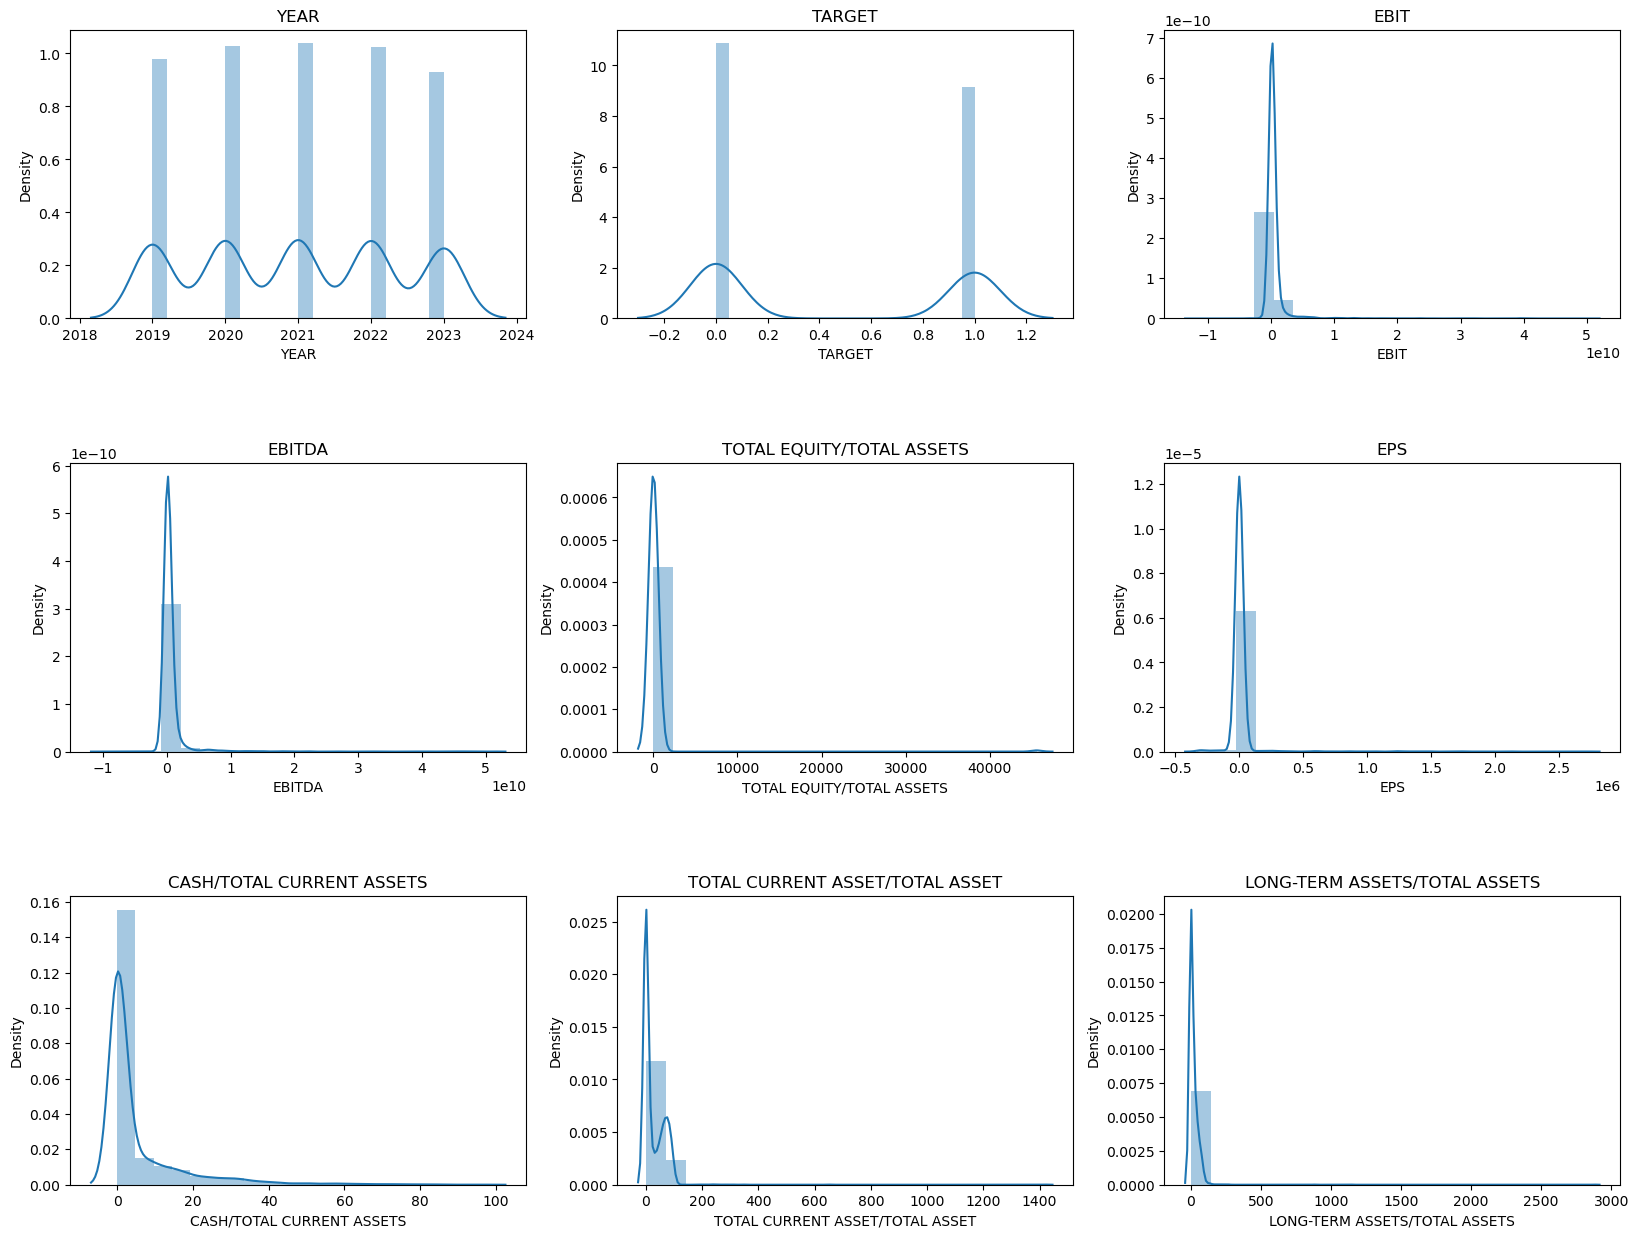

In [22]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

numeric_cols = final_data.select_dtypes(include=['float','int']).columns

def _plot_numeric_classes(final_data, col, bins=10, hist=True, kde=True):
    sns.distplot(final_data[col],
                 bins = bins,
                 hist = hist,
                 kde = kde)

def _distribution_numeric(final_data, numeric_cols, row=3, col=3, figsize=(20, 15), bins = 20):
    '''
    numeric_cols: list các tên cột
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    bins: số lượng bins phân chia trong biểu đồ distribution
    '''
    print('number of numeric field: ', len(numeric_cols))
    assert row*(col-1) < len(numeric_cols)
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        _plot_numeric_classes(final_data, numeric_cols[i-1], bins = bins)
        plt.title(numeric_cols[i-1])
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break

_distribution_numeric(final_data, numeric_cols)

Lable encode cho cột STOCK EXCHANGE

In [23]:
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Mã hóa cột "STOCK_EXCHANGE"
final_data['STOCK EXCHANGE'] = label_encoder.fit_transform(final_data['STOCK EXCHANGE'])


Chuẩn Normalization là quá trình chuyển đổi các giá trị của biến sao cho chúng có độ lớn Euclidean bằng 1. Điều này thường được thực hiện để đảm bảo rằng các biến có thể so sánh được và không bị ảnh hưởng bởi độ lớn tuyệt đối của chúng.

In [24]:
regression_fearture = final_data.columns.tolist()
regression_fearture.remove('CODE')
regression_fearture.remove('NAME')
regression_fearture.remove('YEAR')
regression_fearture.remove('STOCK EXCHANGE')
regression_fearture.remove('TARGET')
regression_fearture

['EBIT',
 'EBITDA',
 'TOTAL EQUITY/TOTAL ASSETS',
 'EPS',
 'CASH/TOTAL CURRENT ASSETS',
 'TOTAL CURRENT ASSET/TOTAL ASSET',
 'LONG-TERM ASSETS/TOTAL ASSETS',
 'QUICK RATIO',
 'Market Value of Total Equity / Book Values of Total Liabilities',
 'Sales/Total Assets',
 'EBIT/Total Assets',
 'Retain Earnings/Total Assets',
 'Working Capitals/Total Asset',
 'ROIC']

In [25]:
final_data[regression_fearture] = final_data[regression_fearture].apply(lambda x: x / np.sqrt(np.sum(x**2)), axis=0)

In [26]:
final_data.describe()

,STOCK EXCHANGE,YEAR,TARGET,EBIT,EBITDA,TOTAL EQUITY/TOTAL ASSETS,EPS,CASH/TOTAL CURRENT ASSETS,TOTAL CURRENT ASSET/TOTAL ASSET,LONG-TERM ASSETS/TOTAL ASSETS,QUICK RATIO,Market Value of Total Equity / Book Values of Total Liabilities,Sales/Total Assets,EBIT/Total Assets,Retain Earnings/Total Assets,Working Capitals/Total Asset,ROIC
count,2992.00000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2.992000e+03,2.992000e+03,2992.000000,2992.000000,2992.000000,2.992000e+03,2992.000000,2992.000000,2992.000000,2992.000000
mean,0.55615,2020.979612,0.456551,0.003441,0.003815,0.001268,0.001931,7.733469e-03,9.294461e-03,0.005224,0.007140,0.005519,2.890197e-03,0.001804,0.002067,0.002995,0.010685
std,0.49692,1.392024,0.498192,0.017958,0.017882,0.018241,0.018183,1.656834e-02,1.574549e-02,0.017523,0.016833,0.017432,1.805492e-02,0.018196,0.018168,0.018038,0.014836
min,0.00000,2019.000000,0.000000,-0.088286,-0.061398,-0.000001,-0.038974,0.000000e+00,1.218686e-07,-0.000273,0.000000,0.000028,7.612643e-07,-0.025599,-0.193280,-0.236155,-0.513380
25%,0.00000,2020.000000,0.000000,0.000139,0.000175,0.000002,0.000043,8.265738e-08,1.883631e-04,0.000097,0.002244,0.000768,4.467237e-04,0.000276,0.000306,0.000501,0.004776
50%,1.00000,2021.000000,0.000000,0.000485,0.000554,0.000004,0.000141,5.013628e-07,3.171660e-04,0.000505,0.003590,0.001745,1.086779e-03,0.000562,0.000746,0.001478,0.008992
75%,1.00000,2022.000000,1.000000,0.001732,0.001944,0.000005,0.000307,7.406873e-03,2.010056e-02,0.007870,0.006213,0.004297,1.975369e-03,0.000978,0.001559,0.003021,0.015037
max,1.00000,2023.000000,1.000000,0.366926,0.311747,0.277849,0.322832,1.373704e-01,4.975780e-01,0.784803,0.507101,0.409986,5.915318e-01,0.681702,0.724227,0.587957,0.092612


In [27]:
final_data

,CODE,NAME,STOCK EXCHANGE,YEAR,TARGET,EBIT,EBITDA,TOTAL EQUITY/TOTAL ASSETS,EPS,CASH/TOTAL CURRENT ASSETS,TOTAL CURRENT ASSET/TOTAL ASSET,LONG-TERM ASSETS/TOTAL ASSETS,QUICK RATIO,Market Value of Total Equity / Book Values of Total Liabilities,Sales/Total Assets,EBIT/Total Assets,Retain Earnings/Total Assets,Working Capitals/Total Asset,ROIC
0,AAA,CTCP Nhựa An Phát Xanh,1,2019,1.0,0.006011,0.006564,0.000002,0.000273,8.434127e-08,0.000218,0.000165,0.003279,0.000693,0.001560,0.000887,0.000548,0.001637,0.011801
1,AAM,CTCP Thủy sản MeKong,1,2019,0.0,0.000076,0.000090,0.000002,0.000077,1.377858e-08,0.000132,0.000451,0.016878,0.012537,0.000079,0.000023,0.000038,0.000337,0.004424
3,AAV,CTCP AAV Group,0,2019,1.0,0.000319,0.000305,0.000003,0.000225,1.079805e-07,0.000108,0.000615,0.003486,0.001962,0.000861,0.000439,0.000271,0.001586,0.010142
6,ABT,CTCP Xuất nhập khẩu Thủy sản Bến Tre,1,2019,0.0,0.000402,0.000374,0.000005,0.000590,7.042488e-08,0.000091,0.000784,0.002727,0.004981,0.000246,0.000241,0.000271,0.000530,0.013435
7,ACC,CTCP Đầu tư và Xây dựng Bình Dương ACC,1,2019,1.0,0.000431,0.000415,0.000003,0.000095,2.447461e-08,0.000163,0.000315,0.005108,0.001178,0.000039,0.000031,0.000047,0.000083,0.015534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,IDC,Tổng Công ty IDICO – CTCP,0,2020,1.0,0.005475,0.007031,0.000002,0.000083,3.252084e-07,0.000078,0.000212,0.005453,0.001569,0.000420,0.000444,0.000276,0.000821,0.005959
578,TTF,CTCP Tập đoàn Kỹ nghệ gỗ Trường Thành,1,2020,1.0,0.000977,0.001183,-0.000001,0.000000,7.181840e-08,0.000239,0.000087,0.000518,0.001021,0.000734,0.000514,-0.008650,-0.004265,0.011815
315,MCO,CTCP Đầu tư và Xây dựng BDC Việt Nam,0,2022,1.0,0.000005,0.000009,0.000002,0.000003,1.694848e-02,0.023011,0.009383,0.003072,0.000297,0.000714,0.000040,0.000383,0.000540,0.001340
317,MDC,CTCP Than Mông Dương - Vinacomin,0,2022,0.0,0.001086,0.001495,0.000001,0.000148,8.625180e-04,0.018405,0.012964,0.002761,0.000200,0.002604,0.000886,0.000445,-0.000567,0.014822


## Feature Selection

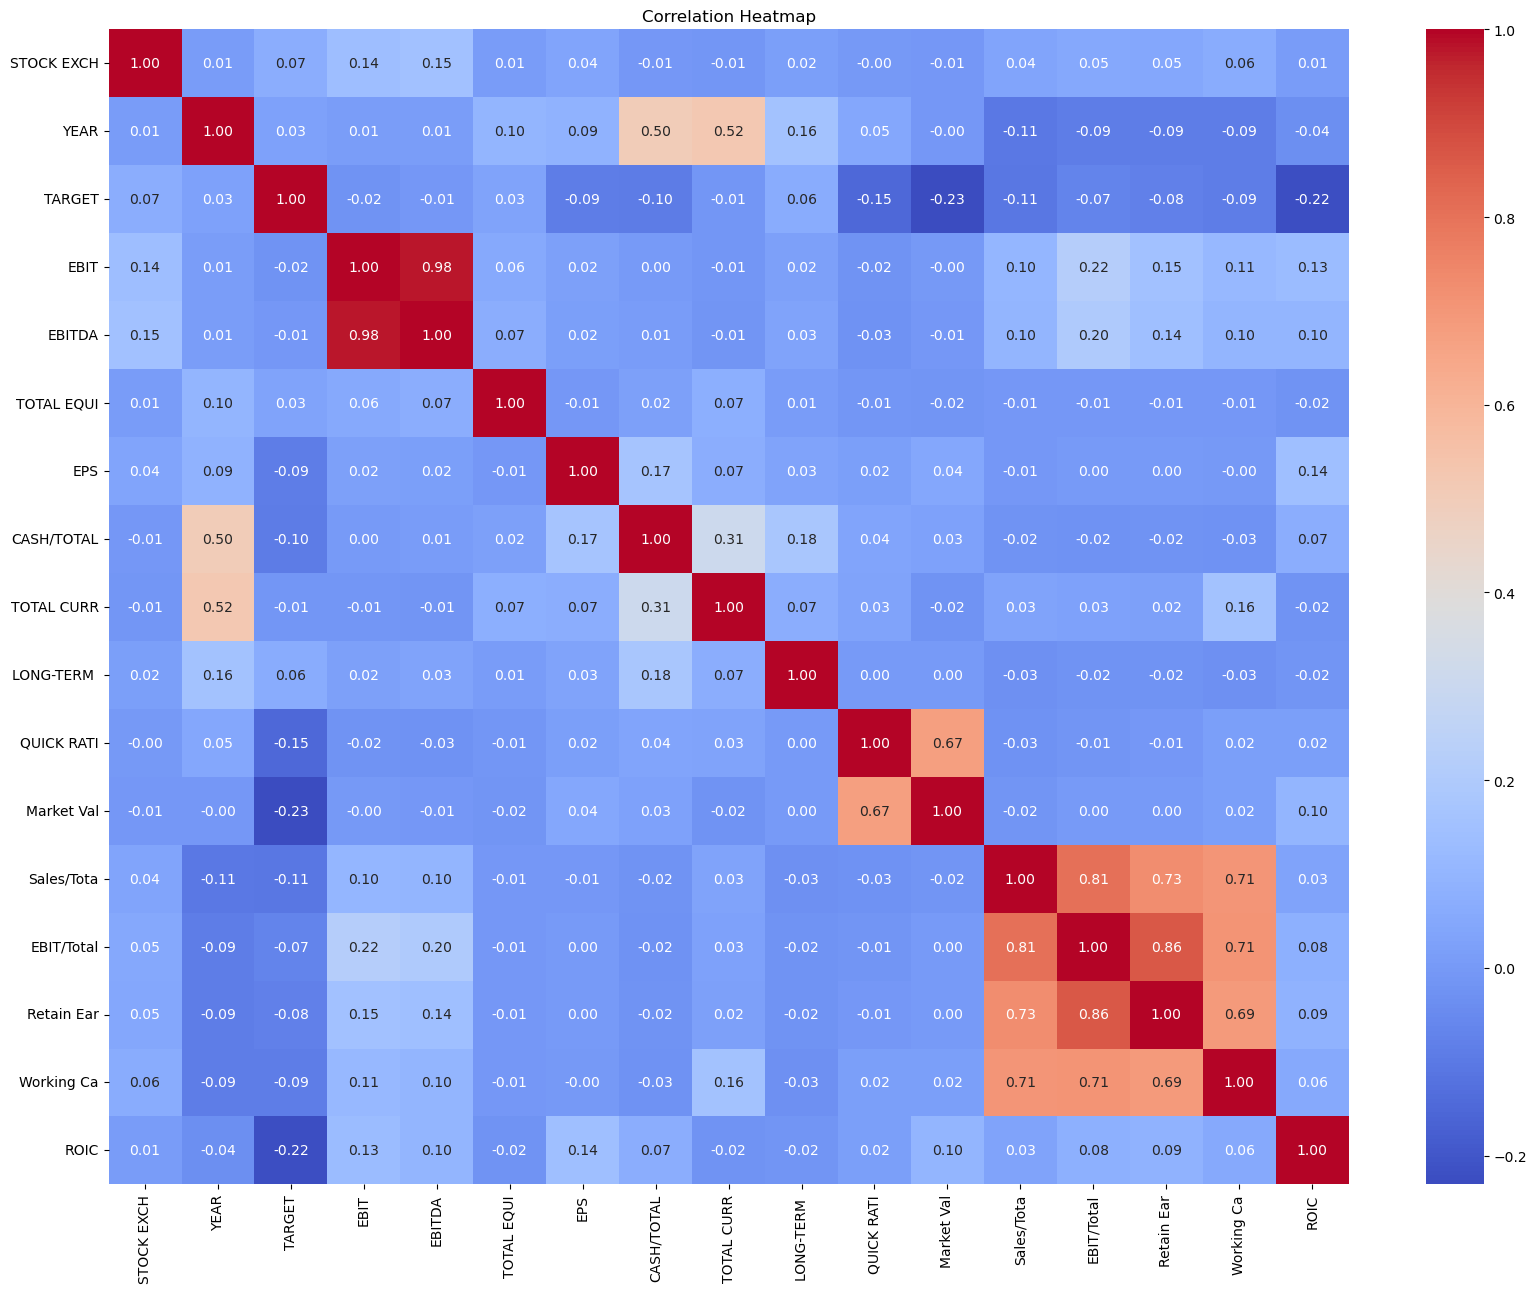

In [28]:
corr_matrix = final_data.drop(['CODE', 'NAME'], axis=1).corr()
column_names = [col[:10] for col in corr_matrix.columns]
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=column_names, yticklabels=column_names)
plt.title('Correlation Heatmap')
plt.show()


In [29]:
final_data.to_csv("final_data.csv", index=False)

In [30]:
final_data

,CODE,NAME,STOCK EXCHANGE,YEAR,TARGET,EBIT,EBITDA,TOTAL EQUITY/TOTAL ASSETS,EPS,CASH/TOTAL CURRENT ASSETS,TOTAL CURRENT ASSET/TOTAL ASSET,LONG-TERM ASSETS/TOTAL ASSETS,QUICK RATIO,Market Value of Total Equity / Book Values of Total Liabilities,Sales/Total Assets,EBIT/Total Assets,Retain Earnings/Total Assets,Working Capitals/Total Asset,ROIC
0,AAA,CTCP Nhựa An Phát Xanh,1,2019,1.0,0.006011,0.006564,0.000002,0.000273,8.434127e-08,0.000218,0.000165,0.003279,0.000693,0.001560,0.000887,0.000548,0.001637,0.011801
1,AAM,CTCP Thủy sản MeKong,1,2019,0.0,0.000076,0.000090,0.000002,0.000077,1.377858e-08,0.000132,0.000451,0.016878,0.012537,0.000079,0.000023,0.000038,0.000337,0.004424
3,AAV,CTCP AAV Group,0,2019,1.0,0.000319,0.000305,0.000003,0.000225,1.079805e-07,0.000108,0.000615,0.003486,0.001962,0.000861,0.000439,0.000271,0.001586,0.010142
6,ABT,CTCP Xuất nhập khẩu Thủy sản Bến Tre,1,2019,0.0,0.000402,0.000374,0.000005,0.000590,7.042488e-08,0.000091,0.000784,0.002727,0.004981,0.000246,0.000241,0.000271,0.000530,0.013435
7,ACC,CTCP Đầu tư và Xây dựng Bình Dương ACC,1,2019,1.0,0.000431,0.000415,0.000003,0.000095,2.447461e-08,0.000163,0.000315,0.005108,0.001178,0.000039,0.000031,0.000047,0.000083,0.015534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,IDC,Tổng Công ty IDICO – CTCP,0,2020,1.0,0.005475,0.007031,0.000002,0.000083,3.252084e-07,0.000078,0.000212,0.005453,0.001569,0.000420,0.000444,0.000276,0.000821,0.005959
578,TTF,CTCP Tập đoàn Kỹ nghệ gỗ Trường Thành,1,2020,1.0,0.000977,0.001183,-0.000001,0.000000,7.181840e-08,0.000239,0.000087,0.000518,0.001021,0.000734,0.000514,-0.008650,-0.004265,0.011815
315,MCO,CTCP Đầu tư và Xây dựng BDC Việt Nam,0,2022,1.0,0.000005,0.000009,0.000002,0.000003,1.694848e-02,0.023011,0.009383,0.003072,0.000297,0.000714,0.000040,0.000383,0.000540,0.001340
317,MDC,CTCP Than Mông Dương - Vinacomin,0,2022,0.0,0.001086,0.001495,0.000001,0.000148,8.625180e-04,0.018405,0.012964,0.002761,0.000200,0.002604,0.000886,0.000445,-0.000567,0.014822
